In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
#import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm")
import time
import json
import string

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

In [2]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [3]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


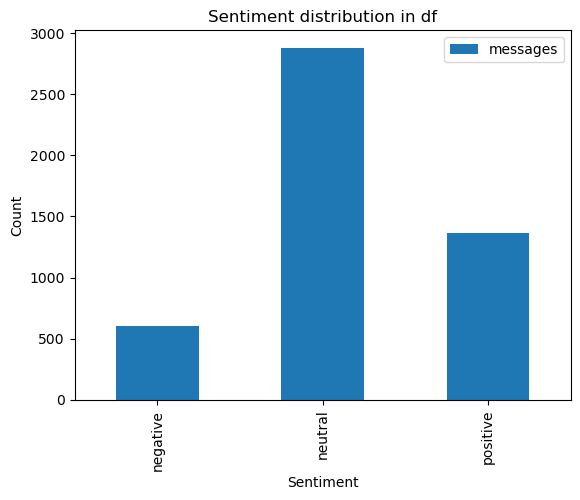

In [4]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [5]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [6]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [7]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [8]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [9]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [10]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [11]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 2
    else:
        return 4

In [12]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [13]:
df['labels'].head(3)

0    2
1    2
2    0
Name: labels, dtype: int64

Number of rows per sentiment:
2    2879
4    1363
0     604
Name: labels, dtype: int64


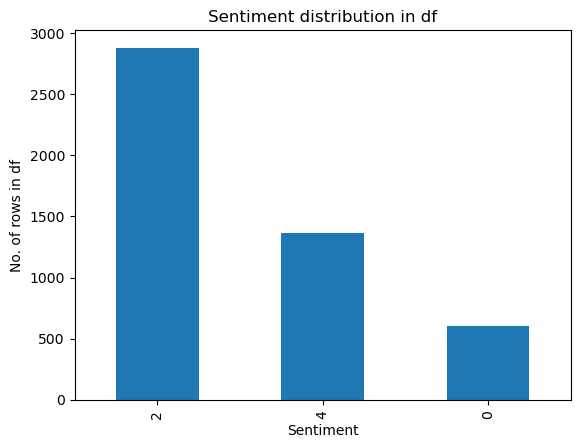

In [14]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [15]:
df.to_csv('preprocessed-text.csv', sep = ',')

In [16]:
# prep for word2vec generation

In [17]:
df[['messages']].head()

,messages
0,"[accord, gran, company, no, plan, move, produc..."
1,"[technopoli, plan, develop, stage, area, no, l..."
2,"[international, electronic, industry, company,..."
3,"[new, production, plant, company, would, incre..."
4,"[accord, company, update, strategy, year, basw..."


code below from: https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim/52067942

In [18]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss() 
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [19]:
corpus = pd.Series(df['messages'].values)

In [20]:
# init word2vec class
w2v_model = Word2Vec(vector_size=300, # 300 dimension vector
                     window=15, # how many neighbors around a particular word
                     min_count=2, # the word needs to appear at least two times in the corpus
                     workers=20, # speed of training
                     sg=1, # sg=1 means this is a skip-gram model
                     negative=5, # num of negative samples
                     sample=1e-5) # sampling rate


# build vovab
w2v_model.build_vocab(corpus)
  
# train the w2v model
start = time.time()
w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, #num of training samples
                epochs=20, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()

print("elapsed time in seconds: " + str(end-start))
# save the word2vec model
w2v_model.save('fin_word2vec20.model')

Loss after epoch 0: 20091.61328125
Loss after epoch 1: 32739.1171875
Loss after epoch 2: 32464.78515625
Loss after epoch 3: 20317.8515625
Loss after epoch 4: 33180.3828125
Loss after epoch 5: 31938.28125
Loss after epoch 6: 17884.875
Loss after epoch 7: 34494.140625
Loss after epoch 8: 18620.765625
Loss after epoch 9: 18211.71875
Loss after epoch 10: 17214.0625
Loss after epoch 11: 15738.78125
Loss after epoch 12: 16358.875
Loss after epoch 13: 27624.5
Loss after epoch 14: 16161.53125
Loss after epoch 15: 13979.5625
Loss after epoch 16: 25105.125
Loss after epoch 17: 15878.6875
Loss after epoch 18: 14163.6875
Loss after epoch 19: 12795.28125
elapsed time in seconds: 0.40104007720947266


In [21]:
fin_w2v_model = Word2Vec.load('fin_word2vec20.model')
words = list(fin_w2v_model.wv.index_to_key)
print('Word2Vec Model Exploration:')
print("Vocab size: " +str(len(words)))

w1= 'buy'
print("Top 3 words similar to buy:",\
     fin_w2v_model.wv.most_similar(positive= w1, topn=3))

w2= 'sell'
print("Top 3 words similar to sell:",\
     fin_w2v_model.wv.most_similar(positive= w2, topn=3))

print("Similarity between 'buy' and 'profit'",\
     str(fin_w2v_model.wv.similarity("buy", "profit")))

print("Similarity between 'sell' and 'loss'",\
     str(fin_w2v_model.wv.similarity("sell", "loss")))

print("Vector distance of 'buy' and 'sell'",\
     str(fin_w2v_model.wv.distance("buy", "sell")))

print("Vector distance of 'profit' and 'loss'",\
     str(fin_w2v_model.wv.distance("profit", "loss")))

print("Vector representation of 'asset':",\
      fin_w2v_model.wv.get_vector("asset"))

Word2Vec Model Exploration:
Vocab size: 3751
Top 3 words similar to buy: [('company', 0.9994236826896667), ('say', 0.9994174838066101), ('use', 0.9994145631790161)]
Top 3 words similar to sell: [('say', 0.9993838667869568), ('business', 0.9993253350257874), ('group', 0.9993122220039368)]
Similarity between 'buy' and 'profit' 0.99805367
Similarity between 'sell' and 'loss' 0.99716735
Vector distance of 'buy' and 'sell' 0.0009071826934814453
Vector distance of 'profit' and 'loss' 0.003501415252685547
Vector representation of 'asset': [ 3.89830098e-02  6.75400048e-02  4.74942178e-02  7.10351095e-02
  5.61063690e-03 -7.90281892e-02  3.79735194e-02  1.22354314e-01
  2.77207661e-02 -7.78725836e-03 -7.46166930e-02 -9.80937108e-02
  3.95099744e-02 -2.90379561e-02 -6.55094832e-02 -4.60763648e-03
 -1.04457010e-02 -4.20046635e-02  1.15571897e-02  2.99415123e-02
 -4.79482375e-02 -2.29049847e-02  3.49454135e-02  1.88742857e-02
  8.75459090e-02  1.64995510e-02 -5.20175546e-02 -1.08432975e-02
 -2.350

**Results:**

Perhaps most notably is the size of the vocabulary. 3745 is not a large word count; chances are the results would be overfit to this specific set of sentences. As always, to have a truly predictive model, far more data would be required.

To access a pretrained Word2Vec model, Google's can be accessed in the following manner:

```python
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
```

In [22]:
word_vec_dict={}
for word in words:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  3751


# Creation of Word2Vec sentence tokens

In [33]:
def word_token(lis):
    token_ls = []
    try:
        for i in lis:
            token_ls.append(np.mean(fin_w2v_model.wv[i]))
    except:
        pass
    return token_ls

In [34]:
my_ls = ['tree', 'house', 'fun', 'ecb']
print(word_token(my_ls))

[-0.0009817771, -0.0016646002, -0.0016491498, -0.00040052578]


In [35]:
df['w2v_tokens'] = df.messages.apply(word_token)

### Preparation of the Gensim Word2Vec Embedding Layer for Keras

In [23]:
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
embedding_matrix = np.zeros((len(fin_w2v_model.wv.index_to_key), 300), dtype=float)
for i in range(len(fin_w2v_model.wv.index_to_key)):
    embedding_vector = fin_w2v_model.wv[fin_w2v_model.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(3751, 300)

### Keras Tokenizer

In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [27]:
tokenizer= Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df.messages.values)

In [28]:
word_index = tokenizer.word_index

In [29]:
print(word_index['short'])

684


In [65]:
len(word_index)

7393

In [37]:
df['keras_tokens'] = df['messages'].apply(tokenizer.texts_to_sequences)

In [42]:
type(df.keras_tokens[0][0])

list

In [43]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [44]:
test_sentence1 = list(traverse(df.keras_tokens[0]))
test_sentence1

[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, 142]

In [45]:
df['keras_tokens'] = df['keras_tokens'].apply(traverse).apply(list)

In [46]:
df.head(2)

,labels,messages,w2v_tokens,keras_tokens
0,2,"[accord, gran, company, no, plan, move, produc...","[-0.0021478878, -0.0011269064, -0.0031040073, ...","[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, ..."
1,2,"[technopoli, plan, develop, stage, area, no, l...","[-0.0010272416, -0.002188268, -0.0023821446, -...","[1087, 80, 104, 933, 89, 193, 868, 482, 1283, ..."


In [49]:
padded_sequences.shape

(4846, 50)

### Train Test Split

In [50]:
df.head(2)

,labels,messages,w2v_tokens,keras_tokens
0,2,"[accord, gran, company, no, plan, move, produc...","[-0.0021478878, -0.0011269064, -0.0031040073, ...","[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, ..."
1,2,"[technopoli, plan, develop, stage, area, no, l...","[-0.0010272416, -0.002188268, -0.0023821446, -...","[1087, 80, 104, 933, 89, 193, 868, 482, 1283, ..."


In [53]:
print(len(df.keras_tokens.values))

4846


In [54]:
print(len(df.labels.values))

4846


In [58]:
X_keras = df.keras_tokens.values
y = df.labels.values

In [60]:
X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X_keras, y, test_size=.3, random_state=42)


print(X_train_keras.shape, X_test_keras.shape)

(3392,) (1454,)


## Pad Sequences

In [61]:
padded_train_seq = pad_sequences(X_train_keras, maxlen=50, padding='post')
padded_test_seq = pad_sequences(X_test_keras, maxlen=50, padding='post')

In [62]:
padded_train_seq.shape

(3392, 50)

In [68]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output 3 nodes as it is either 0,2, or 4(negative, neutral, or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(?, ?, input_length=?),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(3, activation = tf.nn.softmax)
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 6)             60000     
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 60)                18060     
                                                                 
 dense_1 (Dense)             (None, 3)                 183       
                                                                 
Total params: 78,243
Trainable params: 78,243
Non-trainable params: 0
_________________________________________________________________


2022-09-02 12:19:54.392162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
df.head()

,labels,messages,sent_tokens
0,2,"[accord, gran, company, no, plan, move, produc...","[[63], [2670], [3], [193], [80], [366], [54], ..."
1,2,"[technopoli, plan, develop, stage, area, no, l...","[[1087], [80], [104], [933], [89], [193], [868..."
2,0,"[international, electronic, industry, company,...","[[238], [162], [77], [3], [292], [254], [731],..."
3,4,"[new, production, plant, company, would, incre...","[[19], [54], [41], [3], [93], [25], [196], [69..."
4,4,"[accord, company, update, strategy, year, basw...","[[63], [3], [935], [300], [8], [251], [182], [..."


# Creation of Word2Vec sentence tokens

In [ ]:
def word_token(lis):
    token_ls = []
    try:
        for i in lis:
            token_ls.append(np.mean(fin_w2v_model.wv[i]))
    except:
        pass
    return token_ls

In [ ]:
my_ls = ['tree', 'house', 'fun', 'ecb']
print(word_token(my_ls))

In [ ]:
df['w2v_tokens'] = df.messages.apply(word_token)

In [ ]:
df.head()

In [ ]:
--

In [ ]:
len_ls = []
for i in df.sent_tokens:
    len_ls.append(len(i))
    
print(max(len_ls))

In [ ]:
avg_length = 0.0
max_length = 0

for i in df.sent_tokens:
    if len(i) > max_length:
        max_length = len(i)
    avg_length += float(len(i))
    
print('Average headline length: {}'.format(avg_length / float(len(df.sent_tokens))))
print('Max headline length: {}'.format(max_length))

In [ ]:
# Train-Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['messages'], 
                                                        df['labels'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

In [ ]:
X_train.drop("index", axis=1, inplace=True)
X_test.drop("index", axis=1, inplace=True)
Y_train.drop("index", axis=1, inplace=True)
Y_test.drop("index", axis=1, inplace=True)

In [ ]:
### above is fine
### below needs to be redone

code below from: https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim/52067942

**Results:**

Perhaps most notably is the size of the vocabulary. 3056 is not a large word count; chances are the results would be overfit to this specific set of sentences. As always, to have a truly predictive model, far more data would be required. 

To access a pretrained Word2Vec model, Google's can be accessed in the following manner:

```python

import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
```

In [ ]:
from sklearn.manifold import TSNE  ## reduction of dimensions

Visualization of Word2Vec embeddings from documentation at:
https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

In [ ]:

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(fin_w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

### Create sentence vectors:

Below, I am attempting to create a sentence vector to be used in prediction. However, since the dataset is so small, and it isn't trained on outside information, many of the words are not found in the training model, and thus incapable of applying a mean to the vectors. Should I go back and use all of the terms for the model, and train-test-split after? Do I increase the epochs?

In [ ]:
## Below is old, new process started above.

In [ ]:
# Store the vectors for train data in following file
word2vec_filename = './data' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([i for i in sg_w2v_model.wv.vectors], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [ ]:
train_data = pd.read_csv('datatrain_review_word2vec.csv')

In [ ]:
train_data.head()

In [ ]:
# Store the vectors for test data in following file
word2vec_filename = './data' + 'test_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_test.iterrows():
        model_vector = (np.mean([i for i in sg_w2v_model.wv.vectors], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [ ]:
Y_train.to_csv('y_train.csv')

In [ ]:
Y_test.to_csv('y_test.csv')

In [ ]:
X_train

In [ ]:
import time
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier

#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(X_train, Y_train.labels.values)
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))


In [ ]:
from sklearn.metrics import classification_report
X_test = pd.read_csv('datatest_review_word2vec.csv')
X_test.dropna(axis=1, how='all', inplace=True)

y_pred = clf_decision_word2vec.predict(X_test)
print(classification_report(Y_test.labels.values,y_pred, zero_division=0))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.labels.values,y_pred)

Provisional results:

There are likely one of three reasons that the model is exclusively predicting neutral:

1. Imbalance: the data is too imbalanced, thus the model fit is skewed towards a neutral prediction
2. Insufficient data: The data the model trained on is simply not robust enough to have predictive merit
3. Unique language: The technical language in financial headlines is uniquely difficult to perform SA on, compared to "this cheeseburger is delicious".
4. Bad choice of model. Something more robust than a decision tree is needed.

Text Preprocess: https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
Vectorization: https://www.youtube.com/watch?v=MtM9QrCjuK4 
